<a href="https://colab.research.google.com/github/muratali016/Data-Science-and-ML/blob/main/U_net_MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/MyDrive/finger_print.zip" -d "/content/drive/MyDrive/finger_data"

In [10]:
import cv2
import ntpath
import numpy as np
from skimage.filters import threshold_otsu
import math
from PIL import Image

In [11]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
 

In [8]:

def get_mask(image):
    
    image = 255 - image
    kernel = np.ones((1,1),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    
    kernel2 = np.ones((1,1), np.uint8)
    kernel2 = kernel2/np.sum(kernel2)
    image_lp = cv2.filter2D(image,-1,kernel2)

    thresh = threshold_otsu(image_lp)
    mask = image_lp > thresh
    mask = (mask+0)*255
    
    return mask


In [15]:
# Create the masks and save them in a folder
import os
import cv2
img_folder="/content/drive/MyDrive/finger_data/dataset_FVC2000_DB4_B/dataset/train"

Copy_to_path='/content/mask'

for dir1 in os.listdir(img_folder):
    for file in os.listdir(os.path.join(img_folder, dir1)):       
        image_path= os.path.join(img_folder, dir1,  file)          
        image=cv2.imread(image_path)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)           
        image1=np.array(image)
        image1=get_mask(image1)
        cv2.imwrite(Copy_to_path + "/" + f"{(file)}", image1)         
   


In [ ]:
"""from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np

class dataset(Dataset):
  def __init__(self,image_dir,mask_dir,transform=None):
    self.image_dir=image_dir
    self.mask_dir=mask_dir
    self.transform=transform
    self.images=os.listdir(image_dir)
  def __len__(self):
    return len(self.images)
  def __getitem__(self,index):
    img_path=os.path.join(self.image_dir,self.images[index])
    mask_path=os.path.join(self.mask_dir,self.images[index])
    image=np.array(Image.open(img_path).convert("RGB"))
    mask=np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
    mask[mask==255.0]=1.0

    if self.transfrom is not None:
      augmentations=self.transform(image=image,mask=mask)
      image=augmentations["image"]
      mask=augmentations["mask"]
    return image,mask"""



## Unet

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F

In [16]:
# config
LEARNING_RATE = 1e-4
SPLIT=0.2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
EPOCHS = 6
NUM_WORKERS = 4
IMAGE_HEIGHT = 572
IMAGE_WIDTH = 572
PIN_MEMORY = True
DATAPATH = "..."
TRAIN_IMG_DIR = '/content/drive/MyDrive/finger_data/dataset_FVC2000_DB4_B/dataset/train/train_data'
TRAIN_MASK_DIR = '/content/mask'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#------------UNET------------#
import torch
import torch.nn as nn

def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv.to(DEVICE)

def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):

    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(DEVICE)
    return tensor_whose_shape_isTobechanged.to(DEVICE)

class UNet(nn.Module):
    def __init__(self,in_channels=3,classes=1,):
        super(UNet,self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )

    def forward(self, image):   
        x1 = self.down_conv_1(image)       
        x2 = self.max_pool_2x2(x1)       
        x3 = self.down_conv_2(x2)       
        x4 = self.max_pool_2x2(x3)      
        x5 = self.down_conv_3(x4)       
        x6 = self.max_pool_2x2(x5)      
        x7 = self.down_conv_4(x6)       
        x8 = self.max_pool_2x2(x7)       
        x9 = self.down_conv_5(x8)
       
        # decoder (transposed convolutions increase the size)
        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)        
        return x.to(DEVICE)

In [17]:
class CarvanaDataset(Dataset):
    def __init__(self,images,image_dir,mask_dir,transform=None,train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.isTrain = train
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img_path = os.path.join(self.image_dir,self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index].replace(".jpg","_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
        mask[mask == 255.0] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']
            
        return {"image":image,"mask":mask}

In [18]:
images = os.listdir(TRAIN_IMG_DIR)
masks = os.listdir(TRAIN_MASK_DIR)

(160, 160, 3)


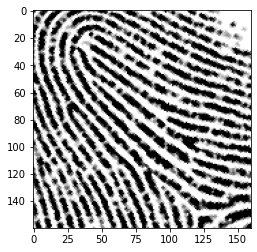

In [19]:
img = np.array(Image.open(TRAIN_IMG_DIR+"/"+images[200]).convert("RGB"))
plt.imshow(img,cmap="gray")
print(img.shape)

(160, 160)


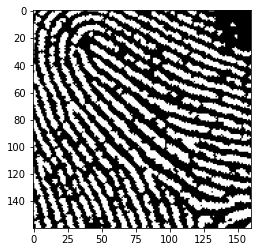

In [21]:
msk = np.array(Image.open(TRAIN_MASK_DIR+"/"+images[200].replace(".jpg","_mask.gif")).convert("L"))
plt.imshow(msk,cmap="gray")
print(msk.shape)

In [ ]:
def fit(model,dataloader,data,optimizer,criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    counter=0
    
    # num of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i,data in tqdm(enumerate(dataloader),total=num_batches):
        counter+=1
        image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs =outputs.squeeze(1)
        loss = criterion(outputs,mask)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss
def validate(model,dataloader,data,criterion):
    print("\n--------Validating---------\n")
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i,data in tqdm(enumerate(dataloader),total=num_batches):
            counter+=1
            image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
            outputs = model(image)
            outputs =outputs.squeeze(1)
            loss = criterion(outputs,mask)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss/counter
    return valid_loss

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Rotate(limit=35,p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()  
])
validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

In [ ]:
def train_test_split(images,splitSize):
    imageLen = len(images)
    val_len = int(splitSize*imageLen)
    train_len = imageLen - val_len
    train_images,val_images = images[:train_len],images[train_len:]
    return train_images,val_images

In [ ]:
train_images_path,val_images_path = train_test_split(images,SPLIT)
train_data = CarvanaDataset(train_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,train_transform,True)
valid_data = CarvanaDataset(val_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,validation_transform,True)
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False)

Epoch 1 of 6
-------------Training---------------


100%|██████████| 160/160 [03:46<00:00,  1.42s/it]



--------Validating---------



100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.2411
Val Loss: 0.2167
Epoch 2 of 6
-------------Training---------------


100%|██████████| 160/160 [03:50<00:00,  1.44s/it]



--------Validating---------



100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Train Loss: 0.1882
Val Loss: 0.2025
Epoch 3 of 6
-------------Training---------------


100%|██████████| 160/160 [03:51<00:00,  1.44s/it]



--------Validating---------



100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.1684
Val Loss: 0.1780
Epoch 4 of 6
-------------Training---------------


100%|██████████| 160/160 [03:53<00:00,  1.46s/it]



--------Validating---------



100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


Train Loss: 0.1536
Val Loss: 0.1764
Epoch 5 of 6
-------------Training---------------


100%|██████████| 160/160 [03:54<00:00,  1.47s/it]



--------Validating---------



100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Train Loss: 0.1424
Val Loss: 0.1412
Epoch 6 of 6
-------------Training---------------


100%|██████████| 160/160 [03:51<00:00,  1.45s/it]



--------Validating---------



100%|██████████| 40/40 [00:22<00:00,  1.80it/s]

Train Loss: 0.1382
Val Loss: 0.1516


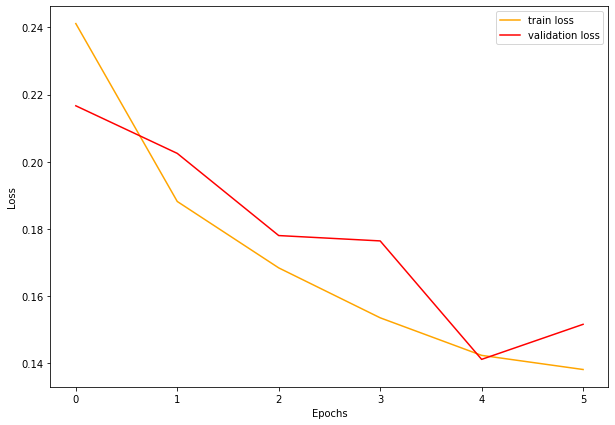

In [ ]:
train_loss = []
val_loss =[]
model = UNet(in_channels=3,classes=2).to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
    val_epoch_loss = validate(model, valid_dataloader, valid_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')


plt.figure(figsize=(10, 7))
plt.plot(train_loss, color="orange", label='train loss')
plt.plot(val_loss, color="red", label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, "./UNET_MODEL.pth")



In [ ]:
model = UNet(in_channels=3,classes=2).to(DEVICE)
weigths=torch.load("/content/UNET_MODEL.pth")
model.load_state_dict(weights)

TypeError: ignored

torch.Size([572, 572])


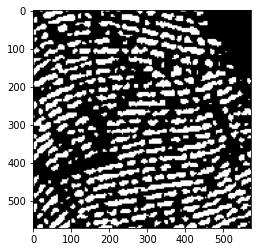

In [ ]:
data = valid_data.__getitem__(10)
plt.imshow(data['mask'],cmap="gray")
valid_data[0]
print(train_data.__getitem__(0)['mask'].shape)

torch.Size([3, 572, 572])
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


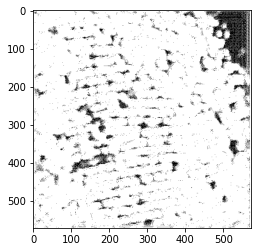

In [ ]:
print(data['image'].shape)
img = data['image'].unsqueeze(0).to(device="cuda")
# model = UNet()
output = model(img)
output = torch.squeeze(output)
output[output>0.0] = 1.0
output[output<=0.0]=0
print(torch.max(output))
disp = output.detach().cpu()
plt.imshow(disp,cmap="gray")

ValueError: ignored

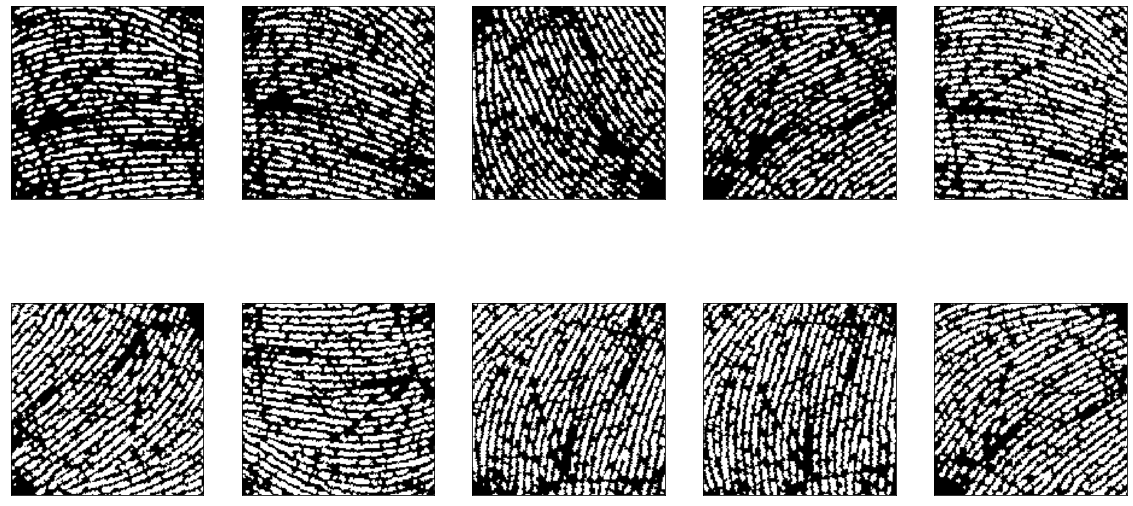

In [ ]:
show_list=[1,2,3,4,5]

mask_list=[]
for i in range(len(valid_data)):
  data = valid_data.__getitem__(i)
  data=data["mask"]
  mask_list.append(data)

plt.figure(figsize=(20,10))
columns = 5 
for i, image in enumerate(mask_list):
    plt.subplot(len(show_list) / columns + 1, columns, i + 1)
    plt.imshow(image,cmap="gray")
    plt.xticks([])
    plt.yticks([]) 

ValueError: ignored

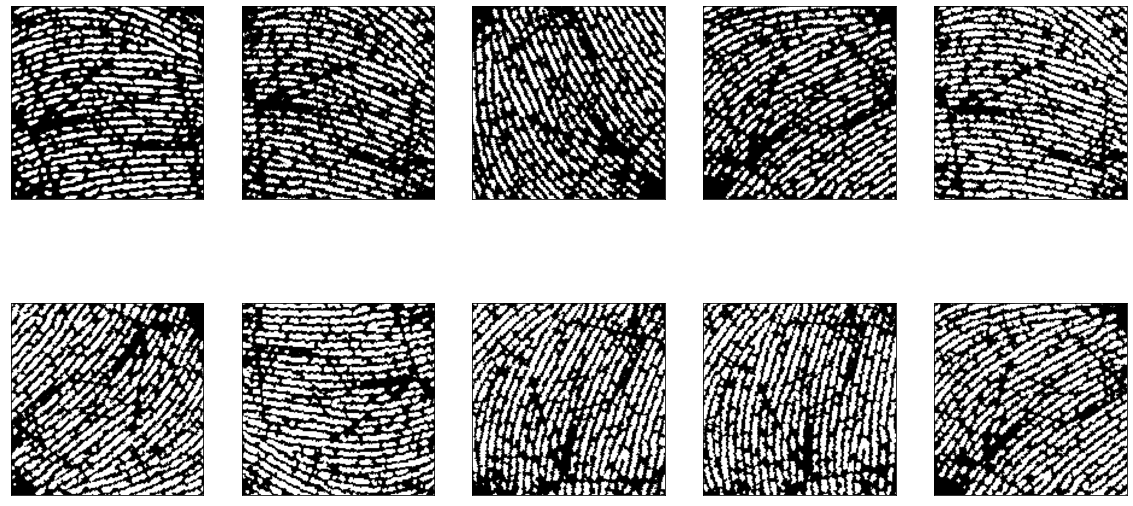

In [ ]:
image_list=[]
for i in range(len(valid_data)):
  data = valid_data.__getitem__(i)
  data=data["image"]
  image_list.append(data)

plt.figure(figsize=(20,10))
columns = 5 
for i, image in enumerate(image_list):
  plt.subplot(len(show_list) / columns + 1, columns, i + 1)
  img = image_list[i]
  img=img.squeeze(0).to(device="cuda")
  img=img[None,:]
  output = model(img)
  output = torch.squeeze(output)
  output[output>0.0] = 1.0
  output[output<=0.0]=0
   
  disp = output.detach().cpu()
  plt.imshow(disp,cmap="gray")
  plt.xticks([])
  plt.yticks([]) 